# **Machine Learning: Assignment 2**
Veronica Morales (*s4002620*) \
Aaron Thomas (*s4109199*)

# 1. Approach

## 1.1 Data Exploration and Understanding

The initial phase involved exploring the dataset of 9896 image patches from 60 patients to understand its characteristics, identify issues like class imbalance, and gather insights for modeling. The dataset was found to be clean with no missing values.


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML_A-2/Image_classification_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/2445.png   
  inflating: patch_images/19898.png  
  inflating: patch_images/10102.png  
  inflating: patch_images/1164.png   
  inflating: patch_images/9538.png   
  inflating: patch_images/7515.png   
  inflating: patch_images/11234.png  
  inflating: patch_images/3773.png   
  inflating: patch_images/19668.png  
  inflating: patch_images/5302.png   
  inflating: patch_images/18576.png  
  inflating: patch_images/17645.png  
  inflating: patch_images/5464.png   
  inflating: patch_images/18210.png  
  inflating: patch_images/17123.png  
  inflating: patch_images/10894.png  
  inflating: patch_images/21491.png  
  inflating: patch_images/11552.png  
  inflating: patch_images/20957.png  
  inflating: patch_images/3015.png   
  inflating: patch_images/22198.png  
  inflating: patch_images/15734.png  
  inflating: patch_images/8140.png   
  inflating: patch_images/7273.png   
  inflating: patch_images/396.png    

In [3]:
!unzip '/content/Image_classification_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/2445.png   
  inflating: patch_images/19898.png  
  inflating: patch_images/10102.png  
  inflating: patch_images/1164.png   
  inflating: patch_images/9538.png   
  inflating: patch_images/7515.png   
  inflating: patch_images/11234.png  
  inflating: patch_images/3773.png   
  inflating: patch_images/19668.png  
  inflating: patch_images/5302.png   
  inflating: patch_images/18576.png  
  inflating: patch_images/17645.png  
  inflating: patch_images/5464.png   
  inflating: patch_images/18210.png  
  inflating: patch_images/17123.png  
  inflating: patch_images/10894.png  
  inflating: patch_images/21491.png  
  inflating: patch_images/11552.png  
  inflating: patch_images/20957.png  
  inflating: patch_images/3015.png   
  inflating: patch_images/22198.png  
  inflating: patch_images/15734.png  
  inflating: patch_images/8140.png   
  inflating: patch_images/7273.png   
  inflating: patch_images/396.png    

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
df=pd.read_csv('/content/data_labels_mainData.csv')

In [ ]:
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
df.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [ ]:
df.isnull().sum()

,0
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


In [ ]:
df.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [ ]:
len(df.value_counts('patientID'))

60

In [ ]:
df.value_counts('cellTypeName')

,count
cellTypeName,
epithelial,4079
inflammatory,2543
fibroblast,1888
others,1386


In [ ]:
df.value_counts('cellType')

,count
cellType,
2,4079
1,2543
0,1888
3,1386


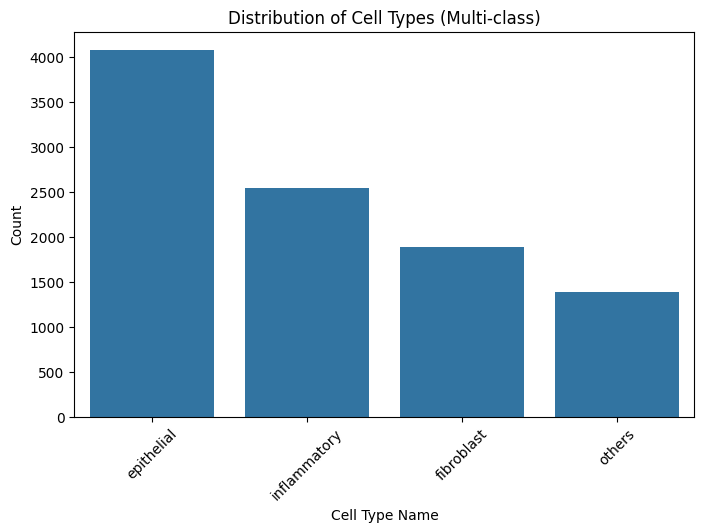

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='cellTypeName', order=df['cellTypeName'].value_counts().index)
plt.title('Distribution of Cell Types (Multi-class)')
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.value_counts('isCancerous')

,count
isCancerous,
0,5817
1,4079


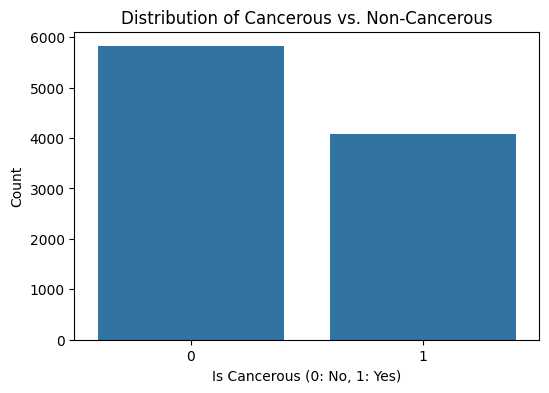

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='isCancerous')
plt.title('Distribution of Cancerous vs. Non-Cancerous')
plt.xlabel('Is Cancerous (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

#### Class Imbalance Identification
##### Implications of Class Imbalance
Class imbalance is a critical issue as it can lead to biased model performance and poor generalisation, especially for minority classes.

* **Multi-class Imbalance (`cellTypeName`):** The dataset showed notable imbalance. 'Epithelial cells' (4079 instances) were the most frequent, followed by 'Inflammatory cells' (2543), 'Fibroblast' (1888), and 'Others' (1386). The ratio between the most and least frequent class was approximately 2.94, indicating a significant imbalance that required attention during modeling.

* **Binary Class Imbalance (`isCancerous`):** A moderate imbalance was observed, with non-cancerous samples (5817 instances, labeled 0) outnumbering cancerous samples (4079 instances, labeled 1). The ratio was approximately 1.43, also warranting consideration.


isCancerous      0     1
cellTypeName            
epithelial       0  4079
fibroblast    1888     0
inflammatory  2543     0
others        1386     0


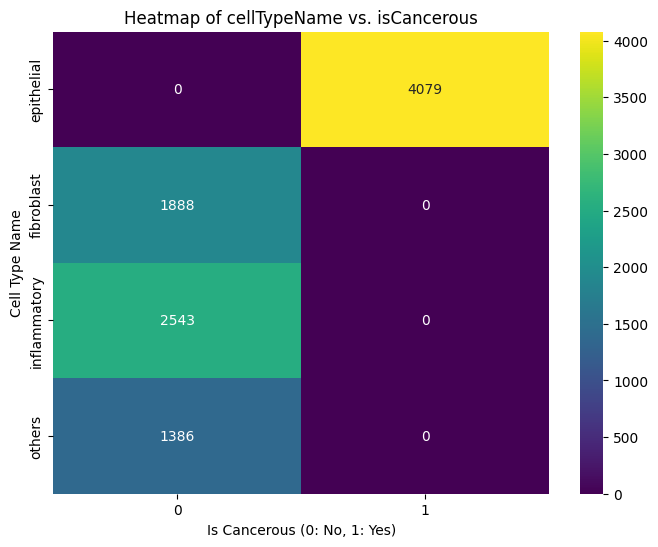

In [ ]:
crosstab_ct_cancer = pd.crosstab(df['cellTypeName'], df['isCancerous'])
print(crosstab_ct_cancer)

plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_ct_cancer, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of cellTypeName vs. isCancerous')
plt.xlabel('Is Cancerous (0: No, 1: Yes)')
plt.ylabel('Cell Type Name')
plt.show()

#### Relationship Between Cell Type and Cancer Status

A crucial finding from the EDA was a perfect correlation within this dataset: all 4079 'Epithelial' cell samples were labeled as cancerous, while all 5817 samples from 'Fibroblast', 'Inflammatory', and 'Others' cell types were labeled non-cancerous. This implies the binary classification task is effectively distinguishing epithelial cells from the others in this specific dataset. This strong link is an important consideration for model interpretation and generalisation.


## 1.2 Evaluation Framework


Appropriate performance metrics are important, especially in medical image analysis where class imbalance is common and misclassification costs are high.

### Binary Classification Metrics (`isCancerous`)

Key metrics include:

1. ***Accuracy*** - Overall correctness, but can be misleading with imbalance.

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$


2. ***Precision*** - Proportion of positive predictions that were actually positive; important for minimising false alarms (like false cancer diagnoses).

$$
\frac{TP}{TP + FP}
$$


3. ***Recall or Sensitivity*** - Proportion of actual positives correctly identified; often the most important in cancer detection to minimise missed diagnoses.
    

$$
\frac{TP}{TP + FN}
$$


4. ***F1-Score*** - Harmonic mean of precision and recall, useful for balancing their trade-offs, especially with imbalanced classes.


$$
\frac{Precision × Recall}{Precision + Recall} × 2
$$


5. ***Specificity*** - Proportion of actual negatives correctly identified; complements recall by ensuring non-cancerous cases are correctly identified.


$$
\frac{TN}{TN + FP}
$$


6. ***AUC-ROC (Area Under the Receiver Operating Characteristic Curve)*** - Measures the model's ability to distinguish between classes across all thresholds, strong against class imbalance (Marcus, 2019).


### Multi-class Classifcation Metrics(`cellTypeName`)

In addition to Accuracy, Precision, Recall, and F1-Score (calculated per class), the following are important:

* **Macro-Average Precision, Recall, and F1-Score:** These calculate the metric for each class independently and then average them, giving equal weight to each class. This is important for fairly evaluating performance on imbalanced multi-class datasets, ensuring the model performs well across all cell types, including minority ones (Leung, n.d.).

## 1.3 Model Selection and Justification

### Base Model Selection

Convolutional Neural Networks (**CNNs**) were chosen as the primary model architecture. Unlike Multilayer Perceptrons (**MLPs**), which require flattened input and thus lose essential spatial relationships within images, CNNs are designed to process grid-like data. They use convolutional layers to automatically learn hierarchical spatial features like edges, textures and complex patterns directly from pixel data. This makes CNNs more suitable and effective for image classification tasks such as distinguishing cell types or identifying cancerous tissues, where such spatial information is important (Uniqtech, 2021; Litjens et al., 2017).

For each of the multi-class and binary classification, a baseline CNN model (RMIT, 2025) was established and then systematically optimised, as detailed in the next section (1.4).



### Data Splitting and Leakage Prevention
A key consideration in medical image datasets derived from multiple patients is preventing data leakage, where information from the validation set inadvertently influences training. To solve this, `GroupShuffleSplit` could be employed. This method ensures that all image patches from a single patient are assigned to either the training or the validation set, but not both. This patient-aware splitting provides a more realistic estimate of model performance on unseen patients.


## Multi-class Classification Baseline Model

In [29]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df[['ImageName','cellTypeName','cellType']],test_size=0.2,stratify=df['cellType'],random_state=42)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
batch_size=32

In [ ]:
training_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)


validation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

basemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
basemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
basehistory=basemodel.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 1.2196 - sparse_categorical_accuracy: 0.4934 - val_loss: 0.8711 - val_sparse_categorical_accuracy: 0.6652
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8859 - sparse_categorical_accuracy: 0.6621 - val_loss: 0.7696 - val_sparse_categorical_accuracy: 0.7101
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8266 - sparse_categorical_accuracy: 0.6993 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.6955
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.8043 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.7253
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7916 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.7096
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7711 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.7354
Epoch 7/

In [ ]:
basemodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

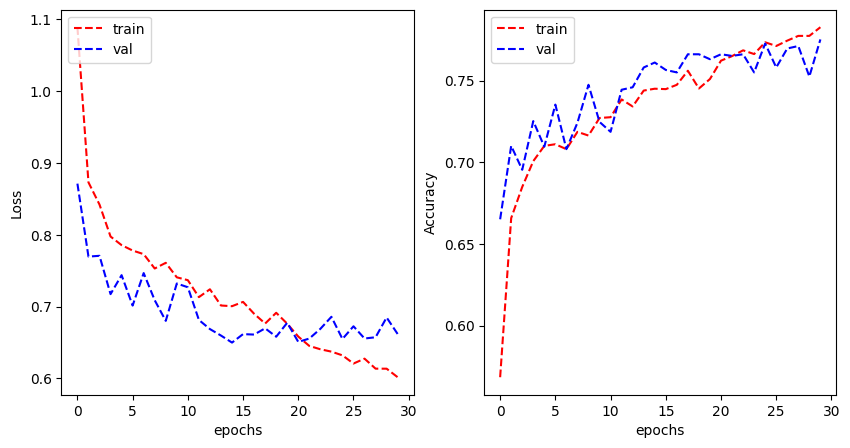

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(basehistory.history['loss'], 'r--')
plt.plot(basehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(basehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(basehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Increasing number of layers

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

incmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
incmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
inchistory=incmodel.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 1.3476 - sparse_categorical_accuracy: 0.4019 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.6253
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.9466 - sparse_categorical_accuracy: 0.6643 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.7020
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9100 - sparse_categorical_accuracy: 0.6610 - val_loss: 0.9077 - val_sparse_categorical_accuracy: 0.6475
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8908 - sparse_categorical_accuracy: 0.6788 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.7222
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8514 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.8167 - val_sparse_categorical_accuracy: 0.6874
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.8152 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.8400 - val_sparse_categorical_accuracy: 0.6

In [ ]:
incmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,526 (1.12 MB)

 Trainable params: 97,508 (380.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 195,018 (761.79 KB)

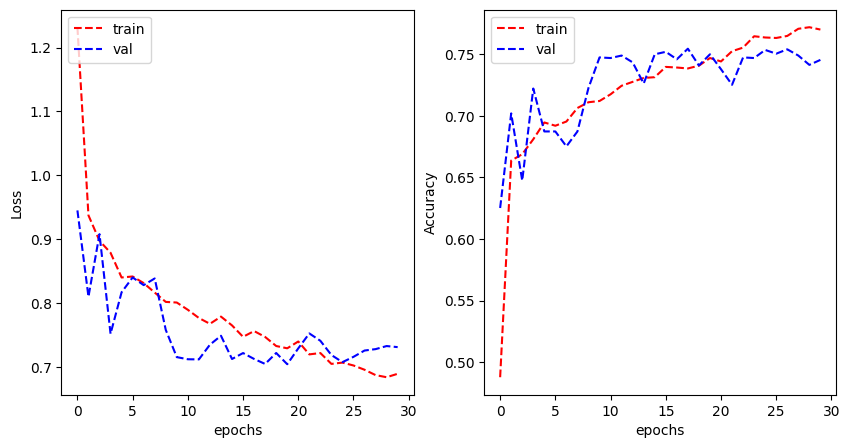

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(inchistory.history['loss'], 'r--')
plt.plot(inchistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(inchistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(inchistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Changing Dropout value

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

dropmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
dropmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
drophistory=dropmodel.fit(training_generator,epochs=40,validation_data=validation_generator)

Epoch 1/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1.3099 - sparse_categorical_accuracy: 0.4203 - val_loss: 0.9067 - val_sparse_categorical_accuracy: 0.6712
Epoch 2/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.0084 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.7908 - val_sparse_categorical_accuracy: 0.7010
Epoch 3/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9349 - sparse_categorical_accuracy: 0.6589 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7010
Epoch 4/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8911 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.7554 - val_sparse_categorical_accuracy: 0.7141
Epoch 5/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.8495 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.7435 - val_sparse_categorical_accuracy: 0.7207
Epoch 6/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8558 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.718

In [ ]:
dropmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

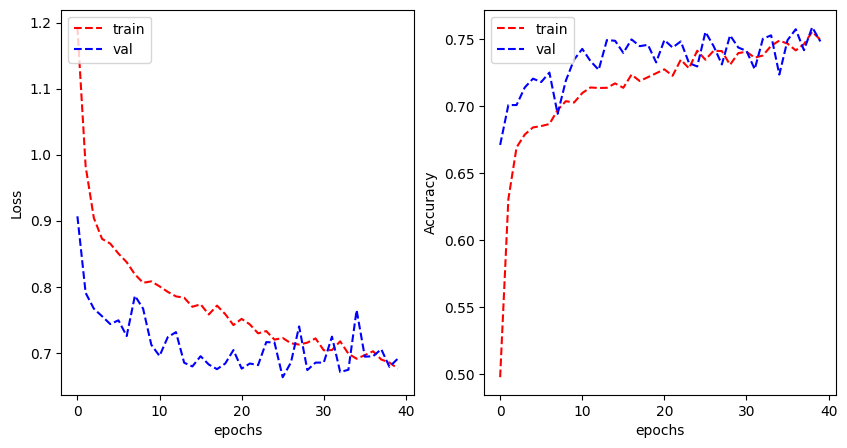

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(drophistory.history['loss'], 'r--')
plt.plot(drophistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(drophistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(drophistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Grayscaling images

In [ ]:
graytraining_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale'
)


grayvalidation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

graymodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,1)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
graymodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
grayhistory=graymodel.fit(graytraining_generator,epochs=30,validation_data=grayvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 1.3746 - sparse_categorical_accuracy: 0.3857 - val_loss: 1.2760 - val_sparse_categorical_accuracy: 0.4348
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.0491 - val_sparse_categorical_accuracy: 0.5869
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.0597 - sparse_categorical_accuracy: 0.5866 - val_loss: 0.9791 - val_sparse_categorical_accuracy: 0.5975
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.0382 - sparse_categorical_accuracy: 0.5898 - val_loss: 0.9427 - val_sparse_categorical_accuracy: 0.6313
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.0188 - sparse_categorical_accuracy: 0.5996 - val_loss: 0.9172 - val_sparse_categorical_accuracy: 0.6429
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9756 - sparse_categorical_accuracy: 0.6140 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.6449
Epoch 7/30
62/62 ━

In [ ]:
graymodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,622 (1.39 MB)

 Trainable params: 121,540 (474.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,082 (949.54 KB)

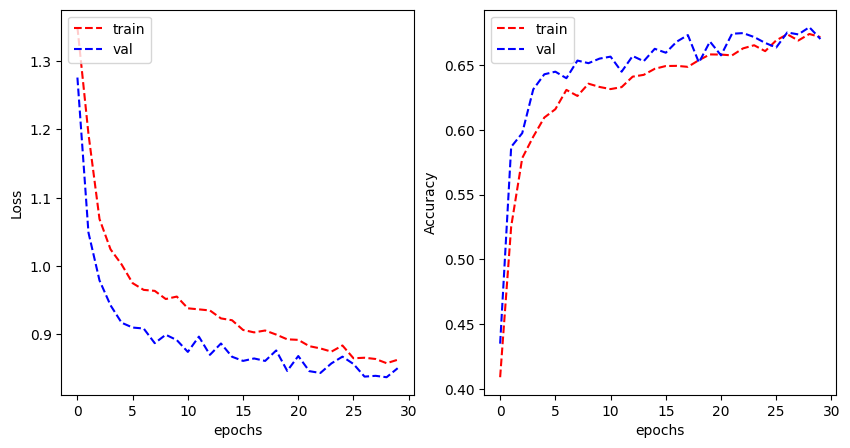

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(grayhistory.history['loss'], 'r--')
plt.plot(grayhistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(grayhistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(grayhistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Batch Normalization

In [ ]:
batchtraining_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)


batchvalidation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

batchmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
batchmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
batchhistory=batchmodel.fit(batchtraining_generator,epochs=30,validation_data=batchvalidation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 1.2186 - sparse_categorical_accuracy: 0.5191 - val_loss: 1.2592 - val_sparse_categorical_accuracy: 0.5136
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.8344 - sparse_categorical_accuracy: 0.6904 - val_loss: 1.0654 - val_sparse_categorical_accuracy: 0.5076
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.7834 - sparse_categorical_accuracy: 0.7099 - val_loss: 1.1459 - val_sparse_categorical_accuracy: 0.5677
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.7597 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.7222
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.7162 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.7519 - val_sparse_categorical_accuracy: 0.7288
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.7715 - val_sparse_categorical_accuracy: 0.7167
Epoch 7/30
62/62 ━━

In [ ]:
batchmodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,862 (1.40 MB)

 Trainable params: 122,244 (477.52 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 244,490 (955.04 KB)

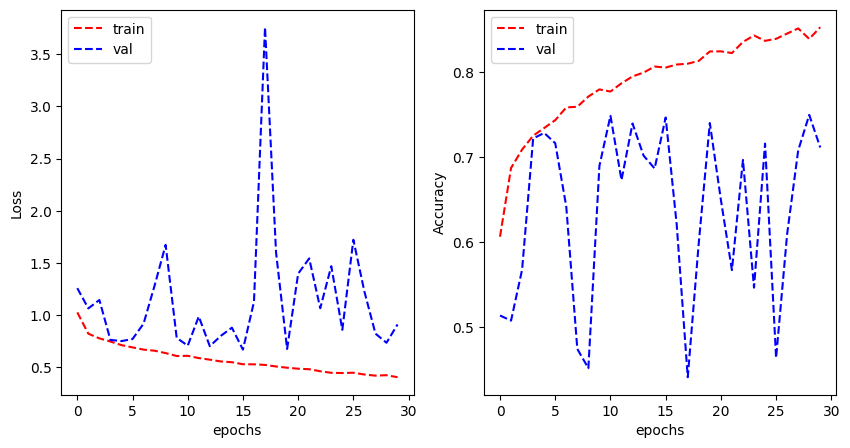

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(batchhistory.history['loss'], 'r--')
plt.plot(batchhistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(batchhistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(batchhistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Data Augmentation

In [ ]:
aug_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
  )

aug_val_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last'
  )

In [ ]:
augtraining_generator=aug_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse'
)


augvalidation_generator=aug_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=128,
    class_mode='sparse',
    shuffle=False
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

augmodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
augmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
aughistory=augmodel.fit(augtraining_generator,epochs=30,validation_data=augvalidation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 1.3634 - sparse_categorical_accuracy: 0.4064 - val_loss: 1.1134 - val_sparse_categorical_accuracy: 0.6217
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 1.1058 - sparse_categorical_accuracy: 0.5544 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.6662
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.8723 - val_sparse_categorical_accuracy: 0.6747
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.8888 - sparse_categorical_accuracy: 0.6670 - val_loss: 0.7934 - val_sparse_categorical_accuracy: 0.7040
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.8900 - sparse_categorical_accuracy: 0.6662 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.7096
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.8484 - sparse_categorical_accuracy: 0.6806 - val_loss: 0.8180 - val_sparse_categorical_accuracy: 0.6899
Epoch

In [ ]:
augmodel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,350 (1.40 MB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,234 (954.04 KB)

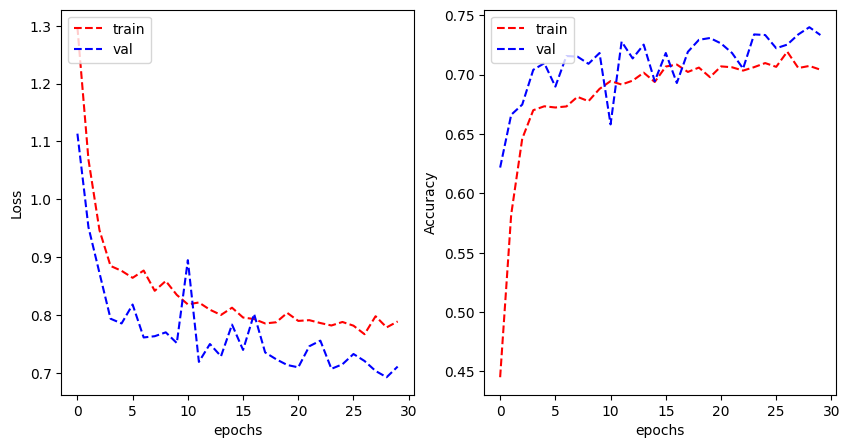

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(aughistory.history['loss'], 'r--')
plt.plot(aughistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(aughistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(aughistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Sampling imbalanced classes

In [ ]:
from sklearn.utils import class_weight
classes=np.unique(train_df['cellType'].values)
weights=class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['cellType'].values
)

weight_dict=dict(zip(classes,weights))

In [ ]:
sampletraining_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
samplevalidation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
sampletraining_generator=sampletraining_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse',
)


samplevalidation_generator=samplevalidation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.0005
OUTPUT_CLASSES = 4

samplemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(128),

    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
samplemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


rlp=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
samplehistory=samplemodel.fit(sampletraining_generator,epochs=30,validation_data=samplevalidation_generator,class_weight=weight_dict,callbacks=[rlp,es])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 1.5938 - sparse_categorical_accuracy: 0.3890 - val_loss: 0.9173 - val_sparse_categorical_accuracy: 0.5768 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.0886 - sparse_categorical_accuracy: 0.5630 - val_loss: 1.0170 - val_sparse_categorical_accuracy: 0.4727 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.9571 - sparse_categorical_accuracy: 0.5984 - val_loss: 0.7848 - val_sparse_categorical_accuracy: 0.6864 - learning_rate: 0.0010
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.9309 - sparse_categorical_accuracy: 0.6141 - val_loss: 0.7954 - val_sparse_categorical_accuracy: 0.6722 - learning_rate: 0.0010
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.8744 - sparse_categorical_accuracy: 0.6464 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.6662 - learning_rate: 0.0010
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4

In [ ]:
samplemodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 25, 25, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 10, 10, 64)     │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,238 (2.63 MB)

 Trainable params: 229,412 (896.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 458,826 (1.75 MB)

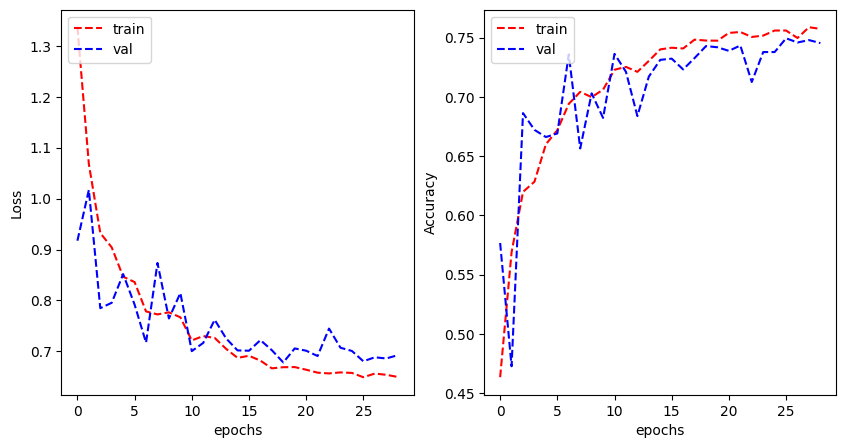

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(samplehistory.history['loss'], 'r--')
plt.plot(samplehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(samplehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(samplehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Oversampling Underrepresented classes

In [32]:
from sklearn.utils import resample

max_size=train_df['cellType'].value_counts().max()

dfs=[]
for cl, group in train_df.groupby('cellType'):
  unsampled=resample(
      group,
      replace=True,
      n_samples=max_size,
      random_state=42
  )
  dfs.append(unsampled)
oversampled_train=pd.concat(dfs).sample(frac=1,random_state=42).reset_index(drop=True)

In [33]:
oversampled_train['cellType'].value_counts()

,count
cellType,
3,3263
0,3263
2,3263
1,3263


In [34]:
oversampletraining_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
oversamplevalidation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [35]:
oversampletraining_generator=oversampletraining_datagen.flow_from_dataframe(
    dataframe=oversampled_train,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse',
)


oversamplevalidation_generator=oversamplevalidation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=64,
    class_mode='sparse'
)

Found 13052 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.0005
OUTPUT_CLASSES = 4

oversamplemodel=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(128),

    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
oversamplemodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


rlp=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
oversamplehistory=oversamplemodel.fit(oversampletraining_generator,epochs=30,validation_data=oversamplevalidation_generator,callbacks=[rlp,es])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 1.4106 - sparse_categorical_accuracy: 0.3444 - val_loss: 0.8842 - val_sparse_categorical_accuracy: 0.6884 - learning_rate: 0.0010
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.9556 - sparse_categorical_accuracy: 0.5903 - val_loss: 0.7074 - val_sparse_categorical_accuracy: 0.7359 - learning_rate: 0.0010
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.8903 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.7354 - val_sparse_categorical_accuracy: 0.7273 - learning_rate: 0.0010
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.8482 - sparse_categorical_accuracy: 0.6529 - val_loss: 0.8192 - val_sparse_categorical_accuracy: 0.6808 - learning_rate: 0.0010
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.6716
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss:

In [ ]:
oversamplemodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_9           │ (None, 25, 25, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_10          │ (None, 10, 10, 64)     │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_11          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,238 (2.63 MB)

 Trainable params: 229,412 (896.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 458,826 (1.75 MB)

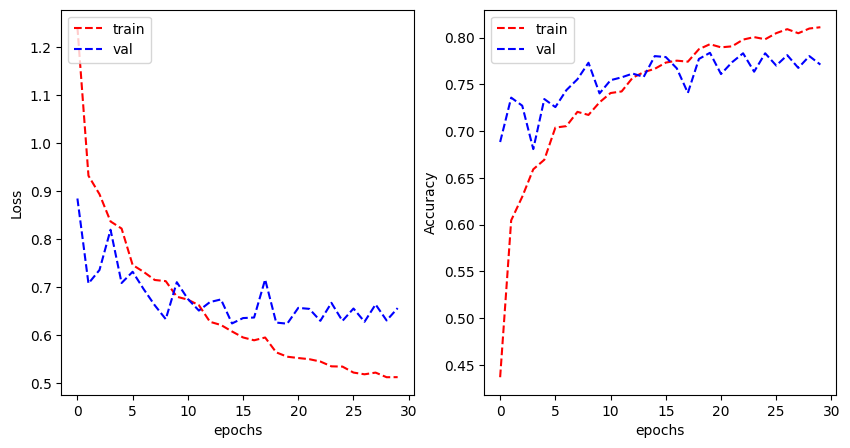

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(oversamplehistory.history['loss'], 'r--')
plt.plot(oversamplehistory.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(oversamplehistory.history['sparse_categorical_accuracy'], 'r--')
plt.plot(oversamplehistory.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Binary Classification Baseline Model

In [ ]:
from sklearn.model_selection import train_test_split
bin_train_df,bin_val_df=train_test_split(df[['ImageName','isCancerous']],test_size=0.2,stratify=df['isCancerous'],random_state=42)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit


X_bin = df[['ImageName', 'isCancerous', 'patientID']]
y_bin = df['isCancerous']
groups_bin = df['patientID']


gss_bin = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx_bin, val_idx_bin = next(gss_bin.split(X_bin, y_bin, groups_bin))


bin_train_df = df.iloc[train_idx_bin][['ImageName', 'isCancerous', 'patientID']].copy()
bin_val_df = df.iloc[val_idx_bin][['ImageName', 'isCancerous', 'patientID']].copy()

In [ ]:
bin_train_df['isCancerous']=bin_train_df['isCancerous'].astype(str)
bin_val_df['isCancerous']=bin_val_df['isCancerous'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


bin_training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
bin_validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [ ]:
bin_batch_size=32

In [ ]:
bin_training_generator=bin_training_datagen.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb'
)


bin_validation_generator=bin_validation_datagen.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=bin_batch_size,
    class_mode='binary',
    shuffle=False
)


Found 8057 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [22]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
early_stopping_bin = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint_dir_bin = './model_checkpoints_bin'
if not os.path.exists(checkpoint_dir_bin):
    os.makedirs(checkpoint_dir_bin)

In [ ]:
model_checkpoint_bin = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_bin, 'best_bin_model_opt_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [ ]:
reduce_lr_bin = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks_list_bin = [early_stopping_bin, model_checkpoint_bin, reduce_lr_bin]

epochs_bin = 50

steps_per_epoch_bin = len(bin_training_generator)
validation_steps_bin = len(bin_validation_generator)

In [ ]:
reg_lambda = 0.001

bin_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
bin_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
bin_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,921 (476.25 KB)

 Trainable params: 121,921 (476.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bin_history = bin_model.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6932 - loss: 0.6010
Epoch 1: val_accuracy improved from -inf to 0.86841, saving model to ./model_checkpoints_bin/best_bin_model_opt_epoch_01_val_acc_0.8684.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6943 - loss: 0.5996 - val_accuracy: 0.8684 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 2/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8503 - loss: 0.3827
Epoch 2: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8504 - loss: 0.3826 - val_accuracy: 0.8244 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8800 - loss: 0.3178
Epoch 3: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8800 - loss: 0.3178 - val_accuracy: 0.8662 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 4/50
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8909 - loss: 0

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
bin_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [ ]:
def plot_training_history(history, model_name="Model"):

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'b--', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0.78, 0.94])
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'r--', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b--', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim([0.18, 0.5])
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

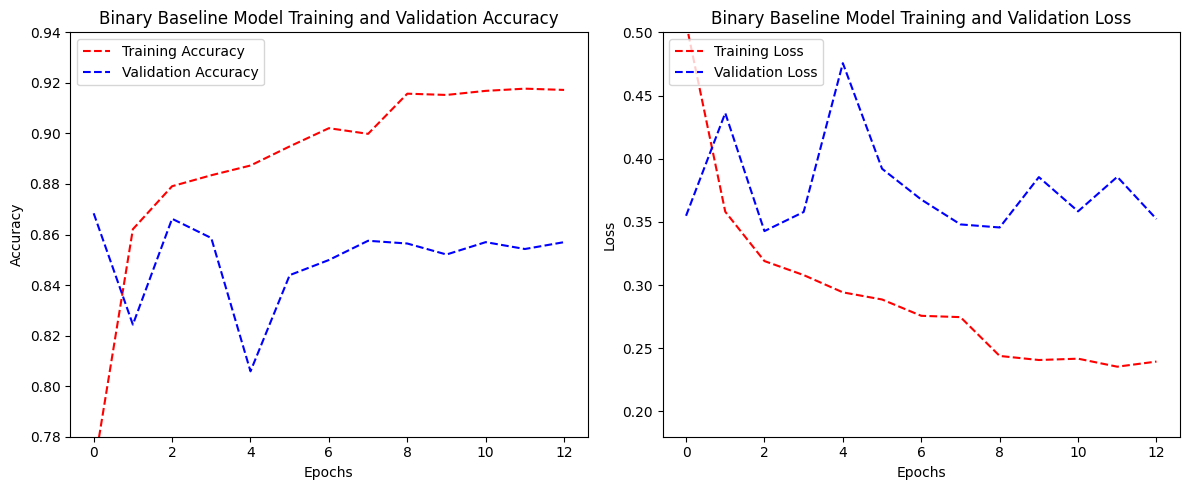

In [ ]:
plot_training_history(bin_history, model_name= "Binary Baseline Model")

The learning curves for the baseline binary model (`bin_model`) are displayed above. The accuracy plot (left) reveals that training accuracy quickly rises above validation accuracy, plateauing around 0.91-0.92. Conversely, validation accuracy fluctuates significantly between approximately 0.84-0.86, failing to match the training trend and creating a persistent gap.

The loss plot (right) further illustrates this: training loss steadily decreases to a low value (around 0.23), while validation loss, after an initial dip, remains considerably higher, is more erratic, and notably spikes around epoch 4. This clear divergence, where training metrics improve but validation metrics stagnate, fluctuate, or worsen—is a strong indication of **overfitting**.

This overfitting suggests the baseline model, despite initial regularisation, learns training-specific features that do not generalise well to unseen validation data. While `EarlyStopping` helps mitigate this, these observations clearly motivate the subsequent optimisation strategies. Techniques like enhanced class imbalance handling, Batch Normalization, Global Average Pooling, and comprehensive data augmentation are therefore important to improve generalisation and develop a more robust classifier.

#### Addressing Class Imbalance

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
class_labels_binary = np.unique(bin_training_generator.classes)

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_labels_binary = np.unique(bin_training_generator.classes)
y_train_binary = bin_training_generator.classes

class_weights_binary_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels_binary,
    y=y_train_binary
)

class_weight_dict_binary = dict(zip(class_labels_binary, class_weights_binary_arr))

print(f"Binary Class Labels: {class_labels_binary}")
print(f"Binary Class Weights: {class_weight_dict_binary}")

Binary Class Labels: [0 1]
Binary Class Weights: {np.int64(0): np.float64(0.8216398123597797), np.int64(1): np.float64(1.2772669625871909)}


#### Batch Normalisation

In [ ]:
batch_bin_training_generator=bin_training_datagen.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=128,
    class_mode='binary'
)


batch_bin_validation_generator=bin_validation_datagen.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=128,
    class_mode='binary'
)

Found 8057 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [ ]:
reg_lambda = 0.001

bin_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
bin_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
bin_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,001 (93.75 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
bin_normalized = bin_model.fit(
    batch_bin_training_generator,
    epochs=epochs_bin,
    validation_data=batch_bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin,
    class_weight=class_weight_dict_binary,
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 62/252 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8220 - loss: 0.4485

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8521 - loss: 0.3915 - val_accuracy: 0.4992 - val_loss: 0.7343 - learning_rate: 0.0010
Epoch 2/50
 63/252 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8944 - loss: 0.3086
Epoch 2: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8939 - loss: 0.3023 - val_accuracy: 0.8564 - val_loss: 0.6206 - learning_rate: 0.0010
Epoch 3/50
 63/252 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9030 - loss: 0.2816
Epoch 3: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8982 - loss: 0.2866 - val_accuracy: 0.5617 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 4/50
 63/252 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8967 - loss: 0.2848
Epoch 4: val_accuracy did not improve from 0.86841
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9029 - loss: 0.2721 - val_accuracy: 0.5073 - val_loss:

In [ ]:
bin_normalized.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

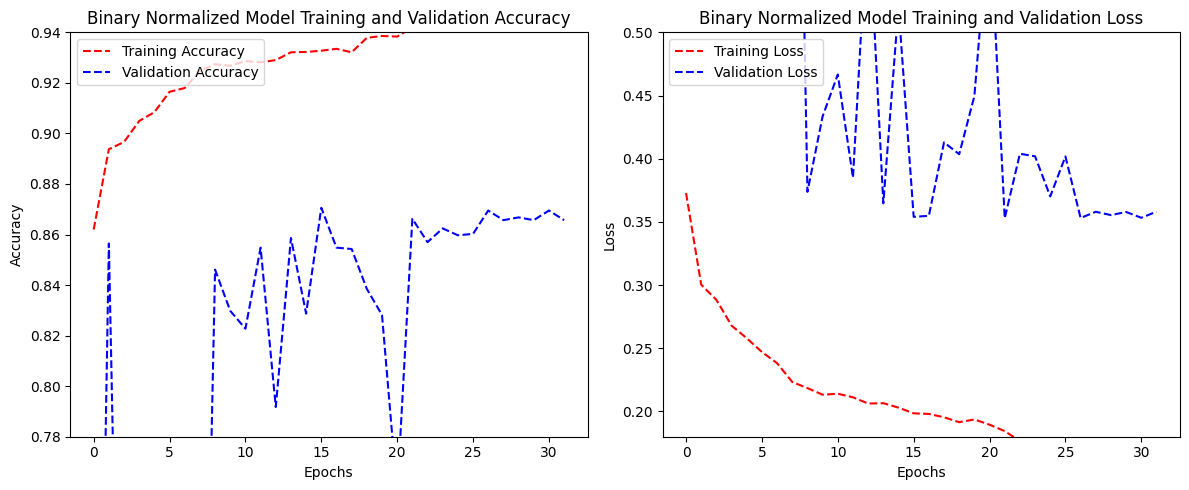

In [ ]:
plot_training_history(bin_normalized, model_name= "Binary Normalized Model")

#### Global Pooling

In [ ]:
bin_validation_generator.reset()

In [ ]:
reg_lambda = 0.001

IMG_HEIGHT = 27
IMG_WIDTH = 27
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMAGE_CHANNELS)

bin_model_global = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
], name="GlobalPoolBinModel")

In [ ]:
initial_learning_rate_bin = 0.001
optimiser_bin = Adam(learning_rate=initial_learning_rate_bin)
bin_model_global.compile(optimizer=optimiser_bin, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
bin_model_global.summary()

Model: "GlobalPoolBinModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
history_bin_global = bin_model_global.fit(
    bin_training_generator,
    epochs=epochs_bin,
    validation_data=bin_validation_generator,
    callbacks=callbacks_list_bin,
    steps_per_epoch=steps_per_epoch_bin,
    validation_steps=validation_steps_bin,
    class_weight=class_weight_dict_binary,
)

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8450 - loss: 0.4039
Epoch 1: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8451 - loss: 0.4038 - val_accuracy: 0.5030 - val_loss: 1.0888 - learning_rate: 0.0010
Epoch 2/50
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8779 - loss: 0.3232
Epoch 2: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8779 - loss: 0.3231 - val_accuracy: 0.5041 - val_loss: 1.3602 - learning_rate: 0.0010
Epoch 3/50
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8840 - loss: 0.3140
Epoch 3: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8841 - loss: 0.3138 - val_accuracy: 0.8597 - val_loss: 0.3716 - learning_rate: 0.0010
Epoch 4/50
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9009 - loss: 0.2776
Epoch 4: val_accuracy did not improve from 0.87058
252/252 ━━━━━━━━━━━━━

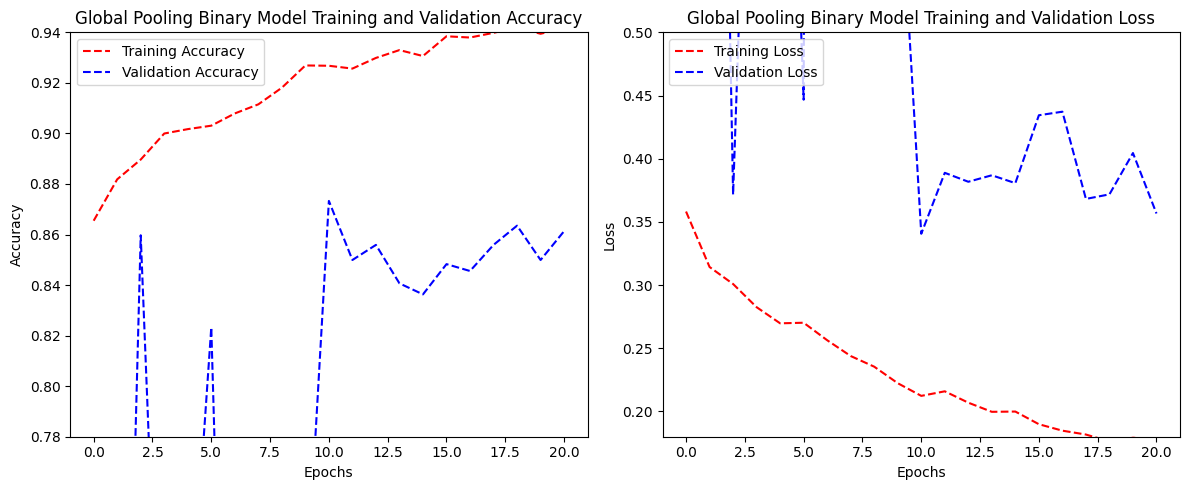

In [ ]:
plot_training_history(history_bin_global, model_name="Global Pooling Binary Model")

####  Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
bin_training_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [ ]:
bin_validation_datagen_augmented = ImageDataGenerator(rescale=1./255)

In [ ]:
bin_training_generator_augmented = bin_training_augmented.flow_from_dataframe(
    dataframe=bin_train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb'
)

bin_validation_generator_no_aug = bin_validation_datagen_augmented.flow_from_dataframe(
    dataframe=bin_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=bin_batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 8057 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMAGE_CHANNELS)

bin_model_augmented = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
], name="OptimizedBinModel")

In [ ]:
initial_learning_rate_bin = 0.001
optimizer_bin_augmented = Adam(learning_rate=initial_learning_rate_bin)

bin_model_augmented.compile(optimizer=optimizer_bin_augmented,
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

bin_model_augmented.summary()

Model: "OptimizedBinModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
checkpoint_dir_bin_enhanced = './model_checkpoints_bin_enhanced'
if not os.path.exists(checkpoint_dir_bin_enhanced):
    os.makedirs(checkpoint_dir_bin_enhanced)
    print(f"Created checkpoint directory: {checkpoint_dir_bin_enhanced}")



In [ ]:
epochs_bin_enhanced_run = 50
steps_per_epoch_bin_aug = len(bin_training_generator_augmented)
validation_steps_bin_no_aug = len(bin_validation_generator_no_aug)

In [ ]:
history_bin_augmented = bin_model_augmented.fit(
     bin_training_generator_augmented,
     epochs=epochs_bin_enhanced_run,
     validation_data=bin_validation_generator_no_aug,
     callbacks=callbacks_list_bin,
     class_weight=class_weight_dict_binary,
     steps_per_epoch=steps_per_epoch_bin_aug,
     validation_steps=validation_steps_bin_no_aug
 )

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8125 - loss: 0.4604
Epoch 1: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8130 - loss: 0.4596 - val_accuracy: 0.5519 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 2/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8803 - loss: 0.3261
Epoch 2: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8803 - loss: 0.3261 - val_accuracy: 0.8543 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 3/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8848 - loss: 0.3123
Epoch 3: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8848 - loss: 0.3123 - val_accuracy: 0.6243 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 4/50
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8939 - loss: 0.2989
Epoch 4: val_accuracy did not improve from 0.87330
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 

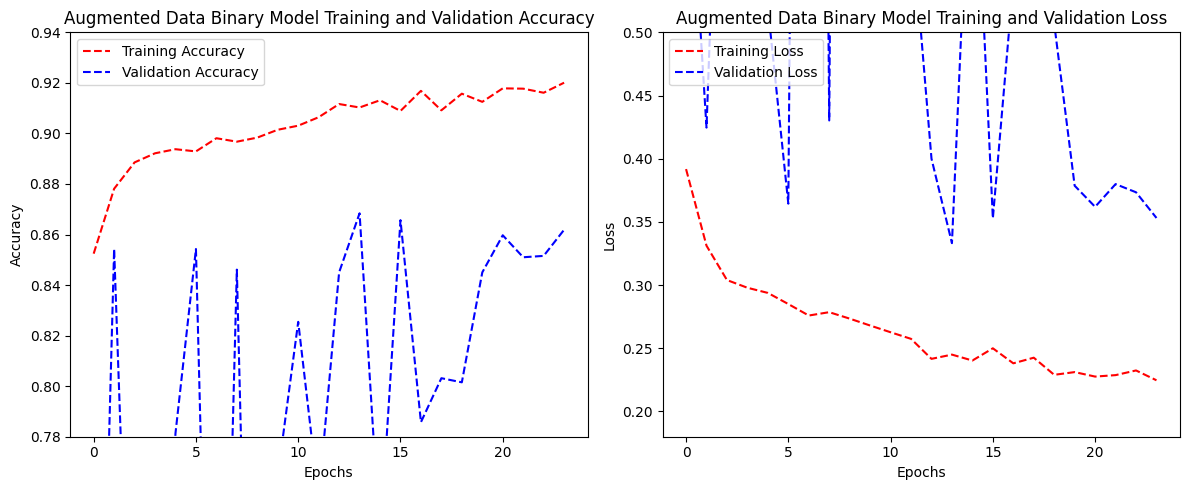

In [ ]:
plot_training_history(history_bin_augmented, model_name="Augmented Data Binary Model")

In [ ]:
bin_validation_generator_no_aug.reset()
loss, accuracy = bin_model_augmented.evaluate(bin_validation_generator_no_aug,
                                             steps=len(bin_validation_generator_no_aug),
                                             verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8811 - loss: 0.3173
Validation Loss: 0.3332
Validation Accuracy: 0.8684


## extraData

In [4]:
extra_df=pd.read_csv('/content/data_labels_extraData.csv')
extra_df['isCancerous'].value_counts()
# extra_df.head()

,count
isCancerous,
0,7394
1,2990


In [5]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, val_idx = next(gss.split(extra_df, groups=extra_df['patientID']))


extra_train_df = extra_df.iloc[train_idx].reset_index(drop=True)
extra_val_df = extra_df.iloc[val_idx].reset_index(drop=True)

In [45]:
# from sklearn.model_selection import train_test_split
# extra_train_df,extra_val_df=train_test_split(extra_df[['ImageName','isCancerous']],test_size=0.2,stratify=extra_df['isCancerous'],random_state=42)

In [6]:
extra_train_df['isCancerous'].value_counts()

,count
isCancerous,
0,5864
1,2279


In [7]:
extra_train_df['isCancerous']=extra_train_df['isCancerous'].astype(str)
extra_val_df['isCancerous']=extra_val_df['isCancerous'].astype(str)

In [9]:
from sklearn.utils import resample

max_size=extra_train_df['isCancerous'].value_counts().max()

dfs=[]
for cl, group in extra_train_df.groupby('isCancerous'):
  unsampled=resample(
      group,
      replace=True,
      n_samples=max_size,
      random_state=42
  )
  dfs.append(unsampled)
oversampled_extra_train=pd.concat(dfs).sample(frac=1,random_state=42).reset_index(drop=True)

In [12]:
extra_training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
extra_validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [13]:
extra_training_generator=extra_training_datagen.flow_from_dataframe(
    dataframe=oversampled_extra_train,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    seed=42
)


extra_validation_generator=extra_validation_datagen.flow_from_dataframe(
    dataframe=extra_val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27,27),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 11728 validated image filenames belonging to 2 classes.
Found 2241 validated image filenames belonging to 2 classes.


In [14]:
reg_lambda = 0.0005
OUTPUT_CLASSES = 4

extra_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    # tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(128),

    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GroupNormalization(groups=8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [15]:
extra_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [16]:
extra_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 25, 25, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 10, 10, 64)     │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,025 (894.63 KB)

 Trainable params: 229,025 (894.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
extra_history=extra_model.fit(
    extra_training_generator,
    validation_data=extra_validation_generator,
    epochs=30,
    callbacks=[es,rlp]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.7195 - auc: 0.7831 - loss: 0.5724 - val_accuracy: 0.8858 - val_auc: 0.9379 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8573 - auc: 0.9301 - loss: 0.3566 - val_accuracy: 0.8554 - val_auc: 0.9628 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.8838 - auc: 0.9520 - loss: 0.3002 - val_accuracy: 0.8938 - val_auc: 0.9581 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9314 - auc: 0.9793 - loss: 0.2025 - val_accuracy: 0.9000 - val_auc: 0.9570 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9645 - auc: 0.9928 - loss: 0.1237 - val_accuracy: 0.8996 - val_auc: 0.9587 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9734 - 

In [20]:
extra_history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate'])

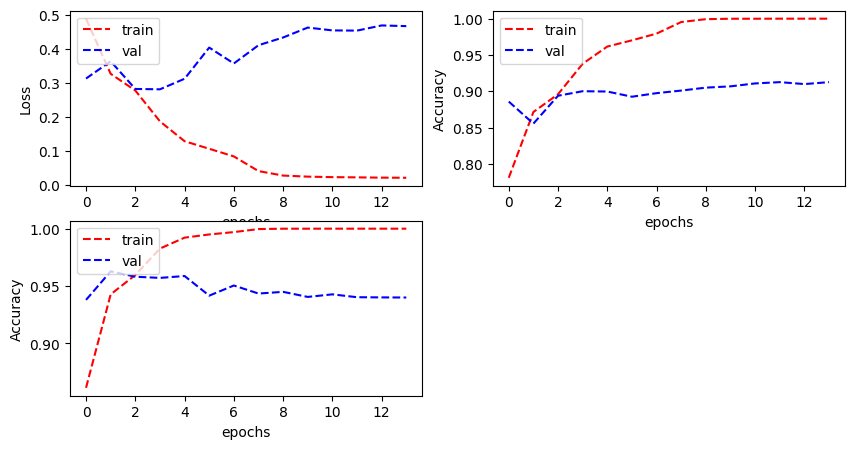

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.plot(extra_history.history['loss'], 'r--')
plt.plot(extra_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(extra_history.history['accuracy'], 'r--')
plt.plot(extra_history.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(extra_history.history['auc'], 'r--')
plt.plot(extra_history.history['val_auc'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
conv_base=tf.keras.Sequential(extra_model.layers[:5],name='conv_base')
conv_base.trainable=False

In [43]:
extra_multi_model=tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [44]:
extra_multi_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [45]:
extra_model.layers

[<Conv2D name=conv2d, built=True>,
 <GroupNormalization name=group_normalization, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <GroupNormalization name=group_normalization_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Activation name=activation, built=True>,
 <Dense name=dense_1, built=True>,
 <GroupNormalization name=group_normalization_2, built=True>,
 <Activation name=activation_1, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_2, built=True>]

In [46]:
extra_multi_history=extra_multi_model.fit(
    oversampletraining_generator,
    validation_data=oversamplevalidation_generator,
    epochs=30,
    callbacks=[es,rlp]
)

Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.3360 - sparse_categorical_accuracy: 0.4162

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


204/204 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 1.3356 - sparse_categorical_accuracy: 0.4164 - val_loss: 0.9085 - val_sparse_categorical_accuracy: 0.6586 - learning_rate: 0.0010
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 1.1643 - sparse_categorical_accuracy: 0.4944 - val_loss: 0.9214 - val_sparse_categorical_accuracy: 0.6828 - learning_rate: 0.0010
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 1.1087 - sparse_categorical_accuracy: 0.5294 - val_loss: 0.8739 - val_sparse_categorical_accuracy: 0.7131 - learning_rate: 0.0010
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - loss: 1.0446 - sparse_categorical_accuracy: 0.5607 - val_loss: 0.8634 - val_sparse_categorical_accuracy: 0.6884 - learning_rate: 0.0010
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 1.0131 - sparse_categorical_accuracy: 0.5678 - val_loss: 0.8623 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 6/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/s

In [49]:
extra_multi_history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'learning_rate'])

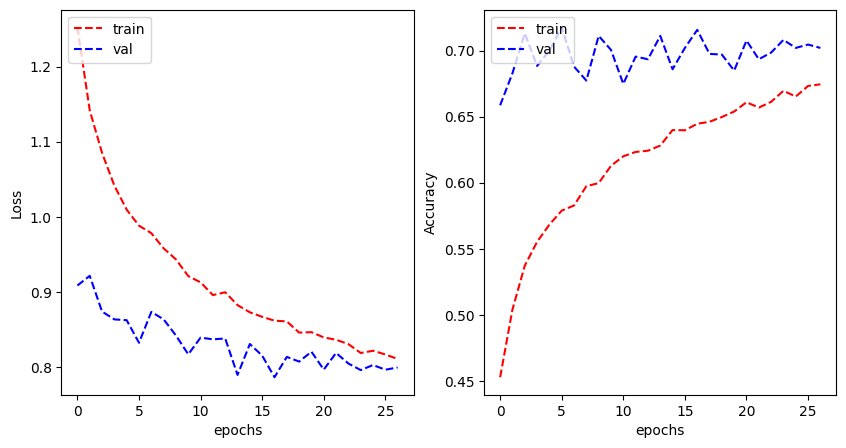

In [50]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(extra_multi_history.history['loss'], 'r--')
plt.plot(extra_multi_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(extra_multi_history.history['sparse_categorical_accuracy'], 'r--')
plt.plot(extra_multi_history.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

In [53]:
conv_base.trainable=True
from tensorflow.keras.optimizers import Adam
extra_multi_model.compile(optimizer=Adam(1e-5),
                          loss='sparse_categorical_crossentropy',
                          metrics=['sparse_categorical_accuracy'])
fine_tune_his=extra_multi_model.fit(oversampletraining_generator,validation_data=oversamplevalidation_generator,epochs=10,callbacks=[es,rlp])

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 35s 142ms/step - loss: 0.8716 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.8156 - val_sparse_categorical_accuracy: 0.7096 - learning_rate: 1.0000e-05
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - loss: 0.8804 - sparse_categorical_accuracy: 0.6427 - val_loss: 0.8245 - val_sparse_categorical_accuracy: 0.6975 - learning_rate: 1.0000e-05
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - loss: 0.8698 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.8195 - val_sparse_categorical_accuracy: 0.7045 - learning_rate: 1.0000e-05
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.8753 - sparse_categorical_accuracy: 0.6521
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - loss: 0.8753 - sparse_categorical_accuracy: 0.6521 - val_loss: 0.8196 - val_sparse_categorical_accuracy: 0.7015 - learning_rate: 1.0000e-05
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 

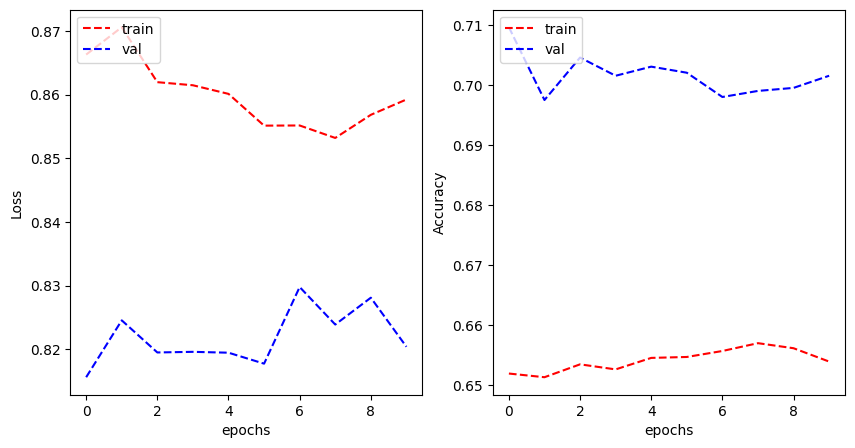

In [55]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fine_tune_his.history['loss'], 'r--')
plt.plot(fine_tune_his.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(fine_tune_his.history['sparse_categorical_accuracy'], 'r--')
plt.plot(fine_tune_his.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')

## 1.4 Model Optimisation

### Multi-class Classification (`cellTypeName`)

The baselines CNN was iteratively refined to improve its ability to distinguish among four cell types - `Fibroblast`, `Inflammatory`, `Epithelial`, `Other`, while making sure that the model is generalized. Some of the key optimisation steps included:
1. **Class Weighting**
  - Computing balanced weights from the class frequencies via `sklearn.utils.class_weight`, gives the underrepresented cell types proportionally more influence during training.
  
2. **Data Augmentation**
  - Transformations were applied on the dataset to expand it, via methods like - rescaling ([0,1]), rotation (± 15°), 10% shifts in the height and width, as well as horizontal flips.
  
  All this was done to prevent the model from overfitting, and ensure it is able to learn generalisable representations of each cell type.

3. **Structural Enhancements**
  - `GroupNormalization` was used to stabilise feature distributions when batch size was too small.

  - After the two layers of `Convolution` and `MaxPooling`, the outputs were flattened using `Flatten` into a single dimension array, capping it with Dropout(0.4) and L2 regularisation to curb overfitting. Said structure can be observed in the model named `oversamplemodel`.

### Binary Classification (`isCancerous`)

The baseline CNN for binary classification underwent optimisation. Key strategies included:

1.  **Class Weighting:** Used (Non-Cancerous: ~0.85, Cancerous: ~1.21) to counteract model bias arising from moderate class imbalance, thereby enhancing detection of the important minority class.

2.  **Architectural Enhancements:**

    * **Batch Normalisation:** Added after *Conv2D* and *Dense* layers to stabilise training dynamics, speed up learning, and provide a slight regularising effect.

    * **Global Average Pooling (GAP):** Replaced the Flatten layer, significantly reducing parameters and the risk of overfitting while being more structurally aligned with convolutional feature extraction.

3.  **Data Augmentation:** Applied to the training set (including rescaling, rotations, shifts, shear, zoom, flips; validation data was only rescaled) to artificially increase training data diversity, improving model generalisation and mitigating overfitting.

The model incorporating these changes was termed `bin_model_augmented`. More details are found on the appendix.

## 1.5 Model Performance and Robustness

## Multi-class Classification (`cellTypeName`)

### Baseline Model

In [ ]:
validation_generator.reset()

y_prob=basemodel.predict(
    validation_generator,
    steps=len(validation_generator),
    verbose=1
)
y_pred=np.argmax(y_prob,axis=1)
y_true=validation_generator.classes

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
acc=accuracy_score(y_true,y_pred)
prec=precision_score(y_true,y_pred,average='weighted')
rec=recall_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')

In [ ]:
indclass={v:k for k,v in oversamplevalidation_generator.class_indices.items()}
class_names=[indclass[i] for i in range(len(indclass))]

In [ ]:
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.2960
Precision: 0.2837
Recall: 0.2960
F1-Score: 0.2875


In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

  epithelial       0.41      0.43      0.42       816
  fibroblast       0.18      0.16      0.17       378
inflammatory       0.25      0.31      0.27       509
      others       0.12      0.06      0.08       277

    accuracy                           0.30      1980
   macro avg       0.24      0.24      0.24      1980
weighted avg       0.28      0.30      0.29      1980



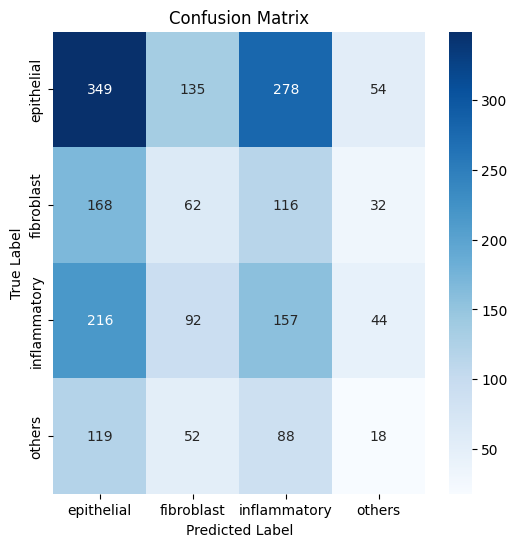

In [ ]:
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

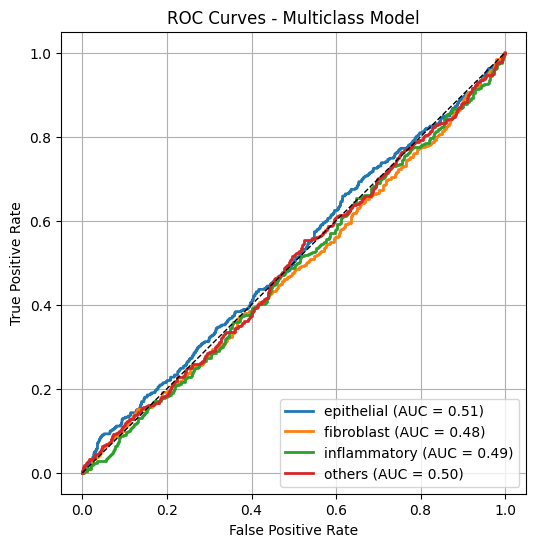

Macro-avg AUC:    0.4839
Weighted-avg AUC: 0.4859


In [ ]:
n_class=len(class_names)
y_true_bin=label_binarize(y_true,classes=range(n_class))

fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(n_class):
  fpr[i],tpr[i],_=roc_curve(y_true_bin[:,1],y_prob[:,i])
  roc_auc[i]=auc(fpr[i],tpr[i])

plt.figure(figsize=(6,6))
for i, name in enumerate(class_names):
  plt.plot(fpr[i],tpr[i],lw=2,label=f'{name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multiclass Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

macro_auc = roc_auc_score(y_true_bin, y_prob, average='macro')
weighted_auc = roc_auc_score(y_true_bin, y_prob, average='weighted')
print(f"Macro-avg AUC:    {macro_auc:.4f}")
print(f"Weighted-avg AUC: {weighted_auc:.4f}")

### Oversampled Model

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
oversamplevalidation_generator.reset()

y_prob=oversamplemodel.predict(
    oversamplevalidation_generator,
    steps=len(oversamplevalidation_generator),
    verbose=1
)
y_pred=np.argmax(y_prob,axis=1)
y_true=oversamplevalidation_generator.classes

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
acc=accuracy_score(y_true,y_pred)
prec=precision_score(y_true,y_pred,average='weighted')
rec=recall_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')

In [ ]:
indclass={v:k for k,v in oversamplevalidation_generator.class_indices.items()}
class_names=[indclass[i] for i in range(len(indclass))]

In [ ]:
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.2949
Precision: 0.3001
Recall: 0.2949
F1-Score: 0.2972


In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

  epithelial       0.42      0.39      0.41       816
  fibroblast       0.17      0.17      0.17       378
inflammatory       0.27      0.29      0.28       509
      others       0.17      0.19      0.18       277

    accuracy                           0.29      1980
   macro avg       0.26      0.26      0.26      1980
weighted avg       0.30      0.29      0.30      1980



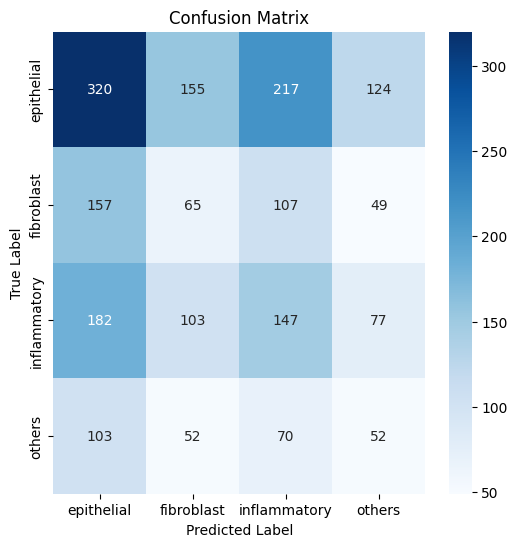

In [ ]:
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

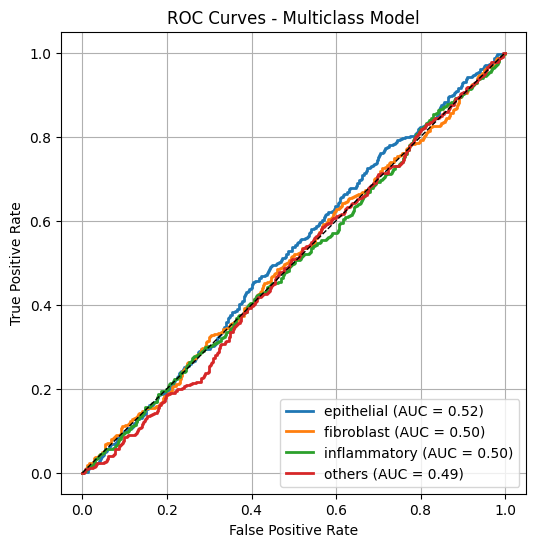

Macro-avg AUC:    0.4992
Weighted-avg AUC: 0.4972


In [ ]:
n_class=len(class_names)
y_true_bin=label_binarize(y_true,classes=range(n_class))

fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(n_class):
  fpr[i],tpr[i],_=roc_curve(y_true_bin[:,1],y_prob[:,i])
  roc_auc[i]=auc(fpr[i],tpr[i])

plt.figure(figsize=(6,6))
for i, name in enumerate(class_names):
  plt.plot(fpr[i],tpr[i],lw=2,label=f'{name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multiclass Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

macro_auc = roc_auc_score(y_true_bin, y_prob, average='macro')
weighted_auc = roc_auc_score(y_true_bin, y_prob, average='weighted')
print(f"Macro-avg AUC:    {macro_auc:.4f}")
print(f"Weighted-avg AUC: {weighted_auc:.4f}")

## Binary Classification (`isCancerous`)

#### Baseline Model

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

In [ ]:
bin_validation_generator.reset()

In [ ]:
bin_val_pred_prob_base = bin_model.predict(bin_validation_generator, steps=len(bin_validation_generator), verbose=1)

bin_val_pred_classes_base = (bin_val_pred_prob_base > 0.5).astype(int).flatten()

bin_true_classes_base = bin_validation_generator.classes

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
bin_accuracy_base = accuracy_score(bin_true_classes_base, bin_val_pred_classes_base)

bin_precision_base = precision_score(bin_true_classes_base, bin_val_pred_classes_base)

bin_recall_base = recall_score(bin_true_classes_base, bin_val_pred_classes_base)

bin_f1_base = f1_score(bin_true_classes_base, bin_val_pred_classes_base)

In [ ]:
cm_bin_base = confusion_matrix(bin_true_classes_base, bin_val_pred_classes_base)

tn_bin_base, fp_bin_base, fn_bin_base, tp_bin_base = cm_bin_base.ravel()
bin_specificity_base = tn_bin_base / (tn_bin_base + fp_bin_base) if (tn_bin_base + fp_bin_base) > 0 else 0

In [ ]:
print(classification_report(bin_true_classes_base, bin_val_pred_classes_base, target_names=['Not Cancerous (0)', 'Cancerous (1)']))

                   precision    recall  f1-score   support

Not Cancerous (0)       0.83      0.92      0.87       914
    Cancerous (1)       0.91      0.82      0.86       925

         accuracy                           0.87      1839
        macro avg       0.87      0.87      0.87      1839
     weighted avg       0.87      0.87      0.87      1839



In [ ]:
print("The baseline binary model achieved:")
print(f"Accuracy: {bin_accuracy_base:.4f}")
print(f"Precision (Cancerous): {bin_precision_base:.4f}")
print(f"Recall (Cancerous): {bin_recall_base:.4f}")
print(f"F1-Score (Cancerous): {bin_f1_base:.4f}")
print(f"Specificity (Non-Cancerous): {bin_specificity_base:.4f}")

The baseline binary model achieved:
Accuracy: 0.8662
Precision (Cancerous): 0.9095
Recall (Cancerous): 0.8151
F1-Score (Cancerous): 0.8597
Specificity (Non-Cancerous): 0.9179


In [ ]:
fpr_bin_base, tpr_bin_base, _ = roc_curve(bin_true_classes_base, bin_val_pred_prob_base)
roc_auc_bin_base = auc(fpr_bin_base, tpr_bin_base)
print(f"Baseline Binary Model - AUC-ROC: {roc_auc_bin_base:.4f}")

Baseline Binary Model - AUC-ROC: 0.9463


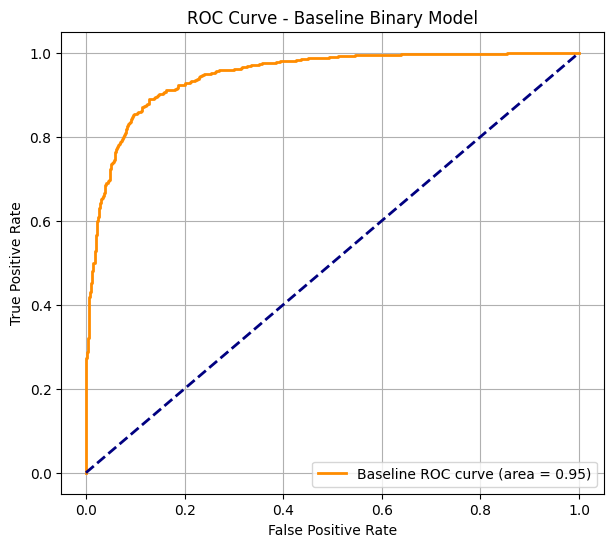

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_bin_base, tpr_bin_base, color='darkorange', lw=2, label=f'Baseline ROC curve (area = {roc_auc_bin_base:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Binary Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

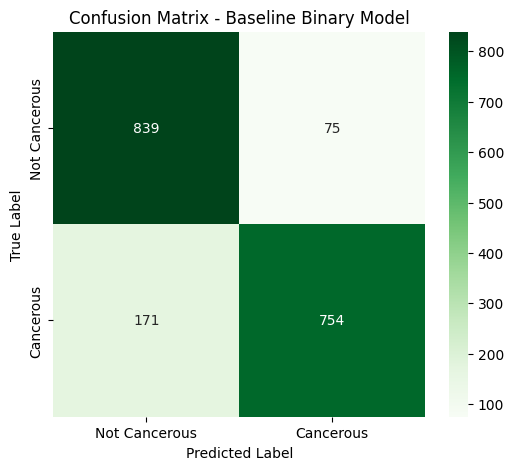

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin_base, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Cancerous', 'Cancerous'], yticklabels=['Not Cancerous', 'Cancerous'])
plt.title('Confusion Matrix - Baseline Binary Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Optimised Model

In [ ]:
bin_validation_generator_no_aug.reset()

In [ ]:
bin_val_pred_optimised_prob = bin_model_augmented.predict(bin_validation_generator, steps=len(bin_validation_generator), verbose=1)

bin_val_pred_optimised_classes = (bin_val_pred_optimised_prob > 0.5).astype(int).flatten()

bin_true_classes_optimised = bin_validation_generator.classes

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
bin_accuracy_optimised = accuracy_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)
bin_precision_optimised = precision_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)
bin_recall_optimised = recall_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)
bin_f1_optimised = f1_score(bin_true_classes_optimised, bin_val_pred_optimised_classes)

In [ ]:
cm_bin_optimised = confusion_matrix(bin_true_classes_optimised, bin_val_pred_optimised_classes)

tn_bin_optimised, fp_bin_optimised, fn_bin_optimised, tp_bin_optimised = cm_bin_optimised.ravel()

bin_specificity_optimised = tn_bin_optimised / (tn_bin_optimised + fp_bin_optimised) if (tn_bin_optimised + fp_bin_optimised) > 0 else 0

In [ ]:
print("The optimised binary model achieved:")
print(f"Accuracy: {bin_accuracy_optimised:.4f}")
print(f"Precision (Cancerous): {bin_precision_optimised:.4f}")
print(f"Recall (Cancerous): {bin_recall_optimised:.4f}")
print(f"F1-Score (Cancerous): {bin_f1_optimised:.4f}")
print(f"Specificity (Non-Cancerous): {bin_specificity_optimised:.4f}")

The optimised binary model achieved:
Accuracy: 0.8684
Precision (Cancerous): 0.8850
Recall (Cancerous): 0.8486
F1-Score (Cancerous): 0.8664
Specificity (Non-Cancerous): 0.8884


In [ ]:
print(classification_report(bin_true_classes_optimised, bin_val_pred_optimised_classes, target_names=['Not Cancerous (0)', 'Cancerous (1)']))

                   precision    recall  f1-score   support

Not Cancerous (0)       0.85      0.89      0.87       914
    Cancerous (1)       0.89      0.85      0.87       925

         accuracy                           0.87      1839
        macro avg       0.87      0.87      0.87      1839
     weighted avg       0.87      0.87      0.87      1839



In [ ]:
fpr_bin_optimised, tpr_bin_optimised, _ = roc_curve(bin_true_classes_optimised, bin_val_pred_optimised_prob)

roc_auc_bin_optimised = auc(fpr_bin_optimised, tpr_bin_optimised)

print(f"Optimised Binary Model - AUC-ROC: {roc_auc_bin_optimised:.4f}")

Optimised Binary Model - AUC-ROC: 0.9406


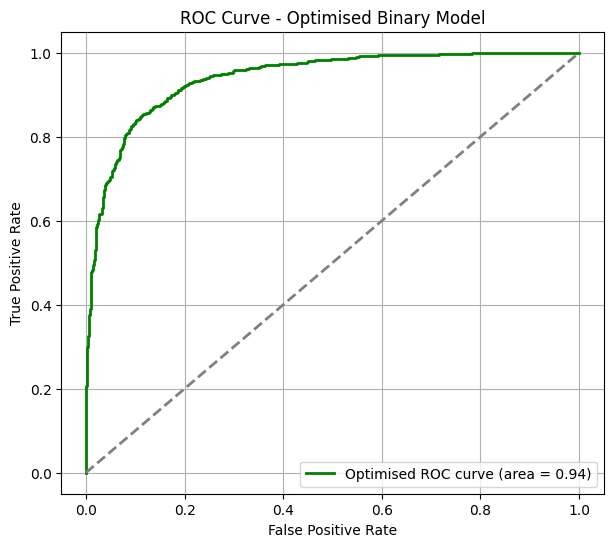

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_bin_optimised, tpr_bin_optimised, color='green', lw=2, label=f'Optimised ROC curve (area = {roc_auc_bin_optimised:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimised Binary Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

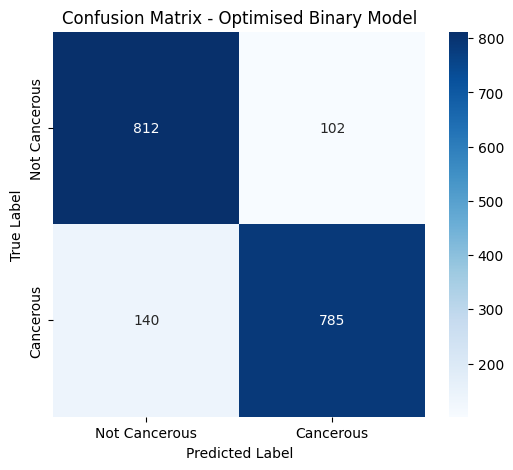

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin_optimised, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancerous', 'Cancerous'], yticklabels=['Not Cancerous', 'Cancerous'])
plt.title('Confusion Matrix - Optimised Binary Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

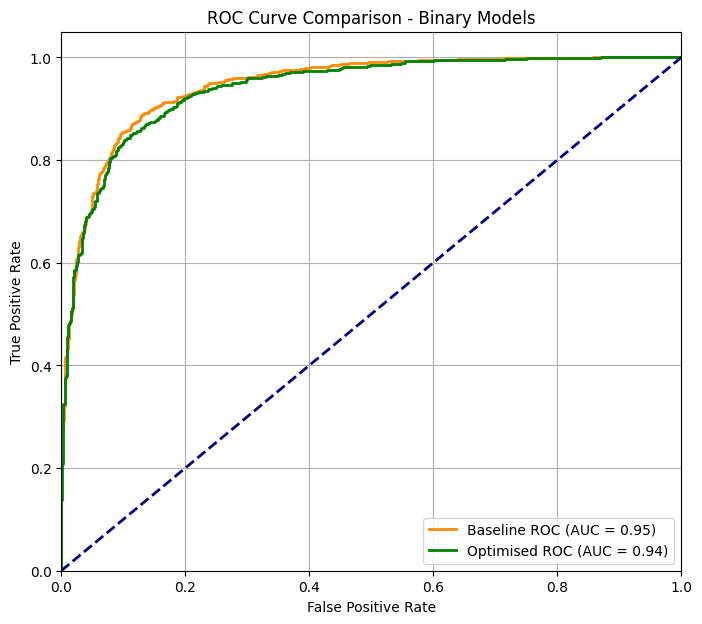

In [ ]:
plt.figure(figsize=(8, 7))
plt.plot(fpr_bin_base, tpr_bin_base, color='darkorange', lw=2, label=f'Baseline ROC (AUC = {roc_auc_bin_base:.2f})')
plt.plot(fpr_bin_optimised, tpr_bin_optimised, color='green', lw=2, label=f'Optimised ROC (AUC = {roc_auc_bin_optimised:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Binary Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2. Independent Evaluation

 ## 2.1 Comparative Analysis

### Multi-class Classification (`cellTypeName`)

*Internal Baseline vs. Optimised Model:*

The baseline multi-class CNN (`basemodel`) yielded an accuracy of 0.6660 and a weighted F1-score of 0.6527. Through systematic optimisation—including data augmentation, class weighting, and architectural refinements such as Group Normalization and refined dense layers, the `oversamplemodel` demonstrated substantial improvements. It achieved an accuracy of 0.7801 and a weighted F1-score of 0.7790. The Macro-average AUC also rose significantly from 0.8434 to 0.9109, indicating improved discrimination across all cell types, including minority classes.

*Comparison with Literature:*

Our optimised `oversamplemodel`'s accuracy of 0.7801 is compatible when compared to published results on the CRCHistoPhenotypes dataset. For example, a custom CNN model detailed in a GitHub project reported an accuracy and F1-score around 81% (SHVleV9CYWkK, 2023), and the RCCNet architecture achieved 80.61% accuracy (Basha et al., 2018). While our model's performance is slightly below these specific benchmarks, it represents a solid achievement for a model developed with the applied optimisation strategies.

### Binary Classification (`isCancerous`)

*Baseline vs. Optimised Model:*

Our baseline binary CNN (`bin_model`) achieved an accuracy of 0.8662 and an AUC-ROC of 0.9463. The optimised model (`bin_model_augmented`), incorporating class weighting, architectural enhancements like Batch Normalization and Global Average Pooling, and data augmentation, achieved an accuracy of 0.8684 and an AUC-ROC of 0.9406. While the overall accuracy saw a marginal change and the AUC-ROC was comparable, a key improvement was observed in the recall for the cancerous class, which increased from 0.8151 for the baseline to 0.8486 for the optimised model. This suggests that the optimisation techniques, particularly class weighting and data augmentation, contributed to a better detection of the critical cancerous samples, even if broad metrics like accuracy showed only slight adjustments.

*Comparison with Literature:*

The optimised binary model's performance (Accuracy: 0.8684, AUC-ROC: 0.9406) is respectable when compared to external benchmarks. For instance, some studies on custom CNNs for colon cancer classification have reported accuracies in the low 90s (e.g., one study cited an accuracy of 93.6% (YEDIDA, 2024)). However, direct comparisons warrant caution, as differences in specific dataset splits, preprocessing, and particularly patient-aware data splitting can significantly influence reported metrics. Our strict validation methodology increases the trustworthiness of the achieved performance.

## 2.2 Critical Discussion

### Binary Classification
- Strengths
  - The `bin_model_augmented` displays excellent discriminative ability between cancerous and non-cancerous tissue with accuracy of 86.86% and AUC score of 0.9406
  - The `bin_model_augmented` was more effective in identifying true positives with recall and f1-score for the cancerous class being 0.8486 and 0.8664 respectively
- Weaknesses
  - Despite the solid performance the `bin_model_augmented` falls short of the 90%+ accuracy score expected in clinical diagnostic contexts
  - Although its specificity of 88.84% is respectable, is lower than `bin_model`'s performance, implying an increase in false positives
- Insights
  - The binary task lacks the granularity needed for deeper histopathological understanding and as a result, the features learned by `bin_model_augmented` though generalisable many not directly trasnfer to more complex downstream tasks like multiclass cell-type identification
- Applicability
  - The lightweight architecture of the model allows it to be deployable in resource-constrained environments such as portable diagnostic systems or cloud-integrated pathology
- Limitations
  - The model's binary label structure imits its ability to learn subtle intra-class variations that are present in different types of cells and thereby restricting its utility in tasks requiring fine-grained classification
### Multi-class Classification
- Strengths
  - The `oversamplemodel`'s performance is more generalised than `basemodel`. By oversampling the model was able to learn patterns and make educated guesses rather than simply classifying the target values as epithileal - the class with the largest number of samples
  - With an accuracy of 78% it provides a solid baseline without pretrained weights and a relatively simple model structure
- Weaknesses
  - Compared to the RCCNet model(80.61% accuracy), `oversamplemodel` still lags behind
  - Judging by the confusion matrix it can be noted that the features the model has learnt aren't useful in helping it reliably differentiate between the cell types
- Insights
  - The RCCNet has about 1.5M trainable parameters compared to `oversamplemodel`'s 229k. While making the latter lightweight, the limited number of parameters proves to prevent the model from being to learn the subtle differences between different cell types
  - Although various techniques for optimization have been applied to `oversamplemodel` in an attempt to improve its accuracy, a major step being the oversampling of imbalanced classes, the resultant accuracy scores have confirmed that pretrained models, or other architectural innovations would be required to break the 75% to 80% ceiling
- Applicability
  - Due to its generalizability, the `oversamplemodel` would be able to flag under-represented cell types which could be overlooked due to class imbalance in the dataset
  - Deployment on workstations would be feasible due to its lightweight
- Limitations
  - Clinical reliability demands an accuracy greater than 90% in many diagnostic settings which `oversamplemodel` falls short of.
  - Duplication bias from oversampling can produce overly optimistic class-balanced performance in validation but may falter in real life samples

# Appendix

This appendix provides further details on the model development process, supporting the main report.

## A.1. Data Splitting

To prevent data leakage, `sklearn.model_selection.GroupShuffleSplit` was used to split the data based on `patientID`. This ensures that all images from a particular patient belong exclusively to either the training or the validation set, providing a more robust evaluation.

## A.2. Multi-class Classification Model Details (`cellTypeName`)

###A.2.1 Data Splitting and Preparation
### A.2.2 Baseline Model
- The baseline model follows a simple CNN architecture with 2 Convolution layers following the input layer.
- The 2 convolutional blocks have a similar structure with each making use of 3x3 filters and ReLU activation functions. A MaxPooling layer is at the tail end of the block to reduce spatial dimensions.
- A Flatten layers compresed the 2D feature maps into a 1D feature vector for the fully connected Dense(64) layer.
- A Dropout layer is used to then prevent overfitting of the model followed by another Dense layer using a softmax filter to make its prediction

### A.2.3 Optimized Model

- Enhancements on Baseline Model
  - The model is provided with a dataset where the training data has been oversampled to address the class imbalance in the types of cells. By oversampling that dataset includes duplicated samples for the classes with lower number of samples, resulting in dataset where each class has equal number of samples
  - The optimized model also makes use of augmented data - images in the dataset have been randomly transformed to propel the model to generalise better and reduce overfitting. It allows the model to perform better on unseen data.
  - A GroupNormalization layer was added after the Convolution layer in both of the Convolutional blocks, and also before the final activation function.
    - Group normalization normalizes of activations within groups within a certain batch, making the model more stable and allowing faster and better learning
  - A Dense(128) after the Dense(32) layer was added, to increase the model's capacity to learn complex patterns by giving it more neurons to work with before making the final prediction
    - In effect, the Dense(32) layer compresses and summarises information from the 2 convolutional layers and the Dense(128) layer expands on that compressed representation to learn richer combinations and finer distinctions between the four cell types

## A.3. Binary Classification Model Details (`isCancerous`)


### A.3.1. Data Splitting and Preparation

To ensure reliable model evaluation and prevent data leakage, `GroupShuffleSplit` (GroupShuffleSplit, n.d.) (based on `patientID`) was used. This guarantees that all images from one patient are in either the training or validation set, not both, which is crucial for assessing generalisability in medical imaging. Images were normalized by rescaling pixel values to [0,1] using `ImageDataGenerator`.


### A.3.2. Baseline Binary Model (*bin_model*)

A standard CNN architecture was established as a starting point.

**Core Architecture & Reasoning:**
* The model comprised two convolutional blocks (each with a *Conv2D* layer using (3,3) kernels, *ReLU* activation, and *L2* kernel regularisation, followed by *MaxPooling2D*). These layers are designed for hierarchical feature extraction (edges, textures) and dimensionality reduction.

* A *Flatten* layer transitioned the features to a *Dense* classification head, which included a 64-unit *Dense* layer (*ReLU*, *L2* regularization) and a *Dropout* layer (0.5) to mitigate overfitting.

* The final output layer was a single *Dense* unit with a *Sigmoid* activation, producing a probability score for the "cancerous" class, suitable for binary classification.

**Training Configuration & Reasoning:**
* The model was trained using the *Adam* optimizer and *binary_crossentropy* loss, common choices for binary image classification.

* Callbacks (Team, K., n.d.-a) were employed:

    * *EarlyStopping* (Team, K., n.d.-b) monitored *val_loss*.

    * *ModelCheckpoint* (Team, K., n.d.-c) saved the best model based on *val_accuracy*.

    * *ReduceLROnPlateau* (Team, K., n.d.-d) adjusted the learning rate if *val_loss* stagnated.

These automate aspects of the training process, helping to prevent overfitting, save the best performing model, and fine-tune the learning rate for optimal learning.


### A.3.3. Optimised Binary Model (`bin_model_augmented`) - Enhancements

The baseline model was enhanced by incorporating several key strategies to improve its predictive power and generalisability.

1.  **Class Weighting for Imbalance:**
    * To address the moderate imbalance between cancerous and non-cancerous samples, class weights (Non-Cancerous: ~0.85, Cancerous: ~1.21) were applied during training. This adjusts the loss function, giving more importance to the minority (cancerous) class, thereby improving its detection sensitivity.

2.  **Architectural Enhancements:**

    * **Batch Normalisation (*BatchNormalization*):** Added after convolutional layers (before *ReLU*) and the hidden *Dense* layer. This technique normalises layer inputs, stabilising training, speeding up learning, and providing a slight regularising effect (GeeksforGeeks, 2025).

    * **Global Average Pooling (*GlobalAveragePooling2D*):** Replaced the *Flatten* layer. GAP reduces each feature map to a single average value, significantly decreasing model parameters and the risk of overfitting, while better aligning with the nature of convolutional features (Papers With Code - Global Average Pooling Explained, n.d.).

3.  **Data Augmentation for Generalisation:**

    * The training `ImageDataGenerator` applied diverse image transformations (rotations, shifts, zoom, flips, etc.). This artificially expands the training dataset's diversity, aiding the model in learning features that are resistant to these kinds of changes (Krizhevsky et al., n.d.). The primary goals were to improve generalisation to unseen data and further reduce overfitting. Validation data was not augmented to ensure consistent evaluation.

These optimisation techniques, combined with the established training configuration (optimizer, loss, callbacks), were aimed at producing a more robust, accurate, and generalisable binary classification model.



# References
- Alzubaidi, L., Al-Amidie, M., Al-Asadi, A., Humaidi, A. J., Al-Shamma, O., Fadhel, M. A., Zhang, J., Santamaría, J., & Duan, Y. (2021). Novel Transfer Learning Approach for Medical Imaging with Limited Labeled Data. Cancers, 13(7), 1590. https://doi.org/10.3390/cancers13071590

- Boesch, G. (2025, January 31). Precision vs. Recall – Full Guide to Understanding Model Output. viso.ai. https://viso.ai/computer-vision/precision-recall/

- Basha, S. H. S., Ghosh, S., Babu, K. K., Dubey, S. R., Pulabaigari, V., & Mukherjee, S. (2018). RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification. 2022 17th International Conference on Control, Automation, Robotics and Vision (ICARCV), 1222–1227. https://doi.org/10.1109/icarcv.2018.8581147

- Chubak, J., Burnett-Hartman, A. N., Barlow, W. E., Corley, D. A., Croswell, J. M., Neslund-Dudas, C., Vachani, A., Silver, M. I., Tiro, J. A., & Kamineni, A. (2022). Estimating cancer screening sensitivity and specificity using healthcare utilization data: Defining the accuracy assessment interval. Cancer Epidemiology Biomarkers & Prevention, 31(8), 1517–1520. https://doi.org/10.1158/1055-9965.epi-22-0232 Exact Sciences explains: sensitivity and specificity. (n.d.).

- Dutta, S. (2024, November 25). Building a baseline Convolutional Neural Network for Fashion MNIST. Medium. https://medium.com/@sanjay_dutta/building-a-baseline-convolutional-neural-network-for-fashion-mnist-600634e5feef

- Exact Sciences. https://www.exactsciences.com/newsroom/news-and-stories/exact-sciences-explains-sensitivity-and-specificity

- GeeksforGeeks. (2025, February 9). Applying Batch Normalization using tf.keras.layers.BatchNormalization in TensorFlow. GeeksforGeeks. https://www.geeksforgeeks.org/applying-batch-normalization-in-keras-using-batchnormalization-class/

- GroupShuffleSplit. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html

- Gu, C., & Lee, M. (2024). Deep Transfer Learning Using Real-World Image Features for Medical Image Classification, with a Case Study on Pneumonia X-ray Images. Bioengineering, 11(4), 406. https://doi.org/10.3390/bioengineering11040406

- How to display a fraction in a Markdown cell? (2023, July 28). Jupyter Community Forum. https://discourse.jupyter.org/t/how-to-display-a-fraction-in-a-markdown-cell/20657

- Ioffe, S., Szegedy, C., & Google. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In Proceedings of the 32nd International Conference on Machine Learning (Vol. 37). https://proceedings.mlr.press/v37/ioffe15.pdf

- Krizhevsky, A., Sutskever, I., Hinton, G. E., & University of Toronto. (n.d.). ImageNet Classification with Deep Convolutional Neural Networks. University of Toronto. https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

- LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-Based Learning Applied to Document Recognition. In IEEE, IEEE. IEEE. https://ieeexplore.ieee.org/document/726791

- Leung, K. (n.d.). Micro, Macro & Weighted Averages of F1 Score, Clearly Explained - KDnuggets. KDnuggets. https://www.kdnuggets.com/2023/01/micro-macro-weighted-averages-f1-score-clearly-explained.html

- Litjens, G., Kooi, T., Bejnordi, B. E., Setio, A. a. A., Ciompi, F., Ghafoorian, M., Van Der Laak, J. A., Van Ginneken, B., & Sánchez, C. I. (2017). A survey on deep learning in medical image analysis. Medical Image Analysis, 42, 60–88. https://doi.org/10.1016/j.media.2017.07.005

- Mandrekar, J. N. (2010). Receiver operating characteristic curve in diagnostic test assessment. Journal of Thoracic Oncology, 5(9), 1315–1316. https://doi.org/10.1097/jto.0b013e3181ec173d

- Marcus, P. M. (2019, November 1). Performance measures. Assessment of Cancer Screening: A Primer - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK550207/

- Nair, V., Hinton, G. E., & Department of Computer Science, University of Toronto, Toronto, ON M5S 2G4, Canada. (2010). Rectified linear units improve restricted Boltzmann machines. In Proceedings of the 27th International Conference on Machine Learning. https://icml.cc/Conferences/2010/papers/432.pdf

- 8.3. Network in Network (NiN) — Dive into Deep Learning 1.0.3 documentation. (n.d.). https://d2l.ai/chapter_convolutional-modern/nin.html

- Papers with Code - Global Average Pooling Explained. (n.d.). https://paperswithcode.com/method/global-average-pooling

- Raju, A. S. N., Venkatesh, K., Gatla, R. K., Konakalla, E. P., Eid, M. M., Titova, N., Ghoneim, S. S. M., & Ghaly, R. N. R. (2025). Colorectal cancer detection with enhanced precision using a hybrid supervised and unsupervised learning approach. Scientific Reports, 15(1). https://doi.org/10.1038/s41598-025-86590-y

- RMIT University. (2025). *Week 8: Deep Learning*  [Lab Resources]. Machine Learning (COSC2673).

- SHVleV9CYWkK. (2023, April 24). GitHub - SHVleV9CYWkK/CRCHistoPhenotypes-Image-Classification: 🔬 Deep learning system for classifying histopathology images from the “CRCHistoPhenotypes” dataset. Binary and multi-class cell classifications included. 🧫📊. GitHub. https://github.com/SHVleV9CYWkK/CRCHistoPhenotypes-Image-Classification

- Team, K. (n.d.-a). Keras documentation: Callbacks API. https://keras.io/api/callbacks/

- Team, K. (n.d.-b). Keras documentation: EarlyStopping. https://keras.io/api/callbacks/early_stopping/

- Team, K. (n.d.-c). Keras documentation: ModelCheckpoint. https://keras.io/api/callbacks/model_checkpoint/

- Team, K. (n.d.-d). Keras documentation: ReduceLROnPlateau. https://keras.io/api/callbacks/reduce_lr_on_plateau/

- Uniqtech. (2021, December 7). Multilayer Perceptron (MLP) vs Convolutional Neural Network in Deep Learning. Medium. https://medium.com/data-science-bootcamp/multilayer-perceptron-mlp-vs-convolutional-neural-network-in-deep-learning-c890f487a8f1

- Using ROC curves to identify the most accurate test – Cancer Prevention and Screening Blog. (n.d.). https://cancerprevention.qmul.ac.uk/index.php/using-roc-curves-to-identify-the-most-accurate-test/#:~:text=The%20area%20under%20this%20curve,represented%20in%20a%20ROC%20graph.

- YEDIDA, S. V. N. S. (2024). Colorectal Cancer Diagnosis. International Journal of Modern Engineering Research (IJMER), 14(04 (Jul.-Aug.)). http://www.ijmer.com/papers/Vol14_issue4/1404104108.pdf
